In [1]:
import numpy as np
import pickle
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from typing import Callable, Type
from matplotlib import pyplot as plt

/Users/priyansh.trivedi/Dev/learning/dl-workinggroup/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Revision

**Goal**: We want to classify sentiments in a document.

**Problem**: How do we convert a document into a set of numbers?

- tokenize text
- make vocab
- convert word to IDs
- use them to make a bag of words document

In [5]:
## lets load up word ids and vocab

data_dir = Path('..') / 'resources' / 'datasets' / 'imdb' / 'proc'
assert data_dir.exists()

with (data_dir / 'wordids_train.pkl').open('rb') as f:
    train_docs = pickle.load(f)

with (data_dir / 'train_labels.pkl').open('rb') as f:
    train_labels = pickle.load(f)

with (data_dir / 'wordids_test.pkl').open('rb') as f:
    test_docs = pickle.load(f)

with (data_dir / 'test_labels.pkl').open('rb') as f:
    test_labels = pickle.load(f)

with (data_dir / 'vocab.json').open('r') as f:
    vocab = json.load(f)

len(train_docs), len(test_docs), len(vocab)

(25000, 25000, 10002)

In [6]:
n_docs = len(train_labels)
n_words = len(vocab)

In [7]:
# Lets do the bag of words representation really quickly
X = torch.zeros((n_docs, n_words), dtype=torch.float32)
Y = torch.tensor(train_labels, dtype=torch.float32).reshape(-1, 1)

# For each document, update a row of this matrix
for i, doc in enumerate(train_docs):
    X[i][doc] = 1

X.shape, Y.shape

(torch.Size([25000, 10002]), torch.Size([25000, 1]))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

def acc(y_pred, y_true):
    return ((y_pred > 0.5).int() == y_true).float().mean()

def train(
    model: torch.nn.Module,
    X: torch.Tensor, 
    Y: torch.Tensor,
    X_valid: torch.Tensor,
    Y_valid: torch.Tensor,
    loss_function: Callable = torch.nn.MSELoss(), 
    optimizer: Type = torch.optim.SGD,
    epochs: int = 200,
    batch_size: int = 32,
    ) -> tuple[torch.nn.Module, list[float]]:
    
    dataloader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True)
    losses = []
    training_accs = []
    validation_accs = []
    
    for epoch in (pbar := tqdm(range(epochs + 1))):
        epoch_loss = 0.0
        epoch_training_acc = []
        model.train()
        for X_batch, Y_batch in dataloader:
            # Do a train step
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_function(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            epoch_loss += loss.item()
            epoch_training_acc.append(acc(Y_pred, Y_batch).item())
    
        # Calculate validation metrics
        with torch.no_grad():
            model.eval()
            y_pred_valid = model(X_valid)
            avg_vlacc = acc(y_pred_valid, Y_valid)
        
        # Log results
        avg_loss = epoch_loss / len(dataloader)
        avg_tracc = sum(epoch_training_acc) / len(epoch_training_acc)
        losses.append(avg_loss)
        training_accs.append(avg_tracc)
        validation_accs.append(avg_vlacc)



        pbar.set_description(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.6f} - Tracc: {avg_tracc:.3f} - Vlacc: {avg_vlacc:.3f}")

    # Visualize loss and accuracy
    plt.figure(figsize=(15, 5), dpi=200)

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss (last_avg: {float(np.mean(losses[-len(losses)//10:])):.6f})')
    plt.xticks()
    plt.yticks()
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accs, label='Training Accuracy', color='orange')
    plt.plot(validation_accs, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy (Training last_avg: {float(np.mean(training_accs[-len(training_accs)//10:])):.6f}, Validation last_avg: {float(np.mean(validation_accs[-len(validation_accs)//10:])):.6f})')
    plt.xticks()
    plt.yticks()
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, losses

In [10]:
# Shuffle the dataset (using np random permutation)
p = np.random.permutation(len(X))
X = X[p]
Y = Y[p]

In [11]:
# Split the dataset 
x_train, x_valid = X[:(int(0.8*n_docs))], X[(int(0.8*n_docs)):]
y_train, y_valid = Y[:(int(0.8*n_docs))], Y[(int(0.8*n_docs)):]

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

(torch.Size([20000, 10002]),
 torch.Size([5000, 10002]),
 torch.Size([20000, 1]),
 torch.Size([5000, 1]))

In [12]:
# Brr lets never do it ourselves
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

(torch.Size([20000, 10002]),
 torch.Size([5000, 10002]),
 torch.Size([20000, 1]),
 torch.Size([5000, 1]))

In [13]:
y_train.dtype

torch.float32

In [32]:
class NonLin(torch.nn.Module):

    def __init__(self, n_words):
        super().__init__()
        
        self.t1 = nn.Linear(n_words, 100, bias=False) # 10002 -> 32
#         self.drop1 = nn.Dropout(0.8)
#         self.batchnorm1 = nn.BatchNorm1d(32)
#         self.t2 = nn.Linear( 100, 50, bias=False) # 32 -> 1
#         self.drop2 = nn.Dropout(0.5)
#         self.batchnorm2 = nn.BatchNorm1d(12)
        self.t3 = nn.Linear(100, 1)
        
    def forward(self, x):

        # Layer 1
        x = self.t1(x)
#         x = self.batchnorm1(x)
#         x = torch.relu(x)
#         x = self.drop1(x)
        
        # Layer 2
#         x = self.t2(x)
# #         x = self.batchnorm2(x)
#         x = torch.relu(x)
#         x = self.drop2(x)
        
        # Layer 3
        x = self.t3(x)
        x = torch.sigmoid(x)
        return x


In [33]:
model = NonLin(n_words)
lfn = torch.nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 40

print(model)

NonLin(
  (t1): Linear(in_features=10002, out_features=100, bias=False)
  (t3): Linear(in_features=100, out_features=1, bias=True)
)


Epoch 40/40 - Loss: 0.027306 - Tracc: 0.993 - Vlacc: 0.851: 100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


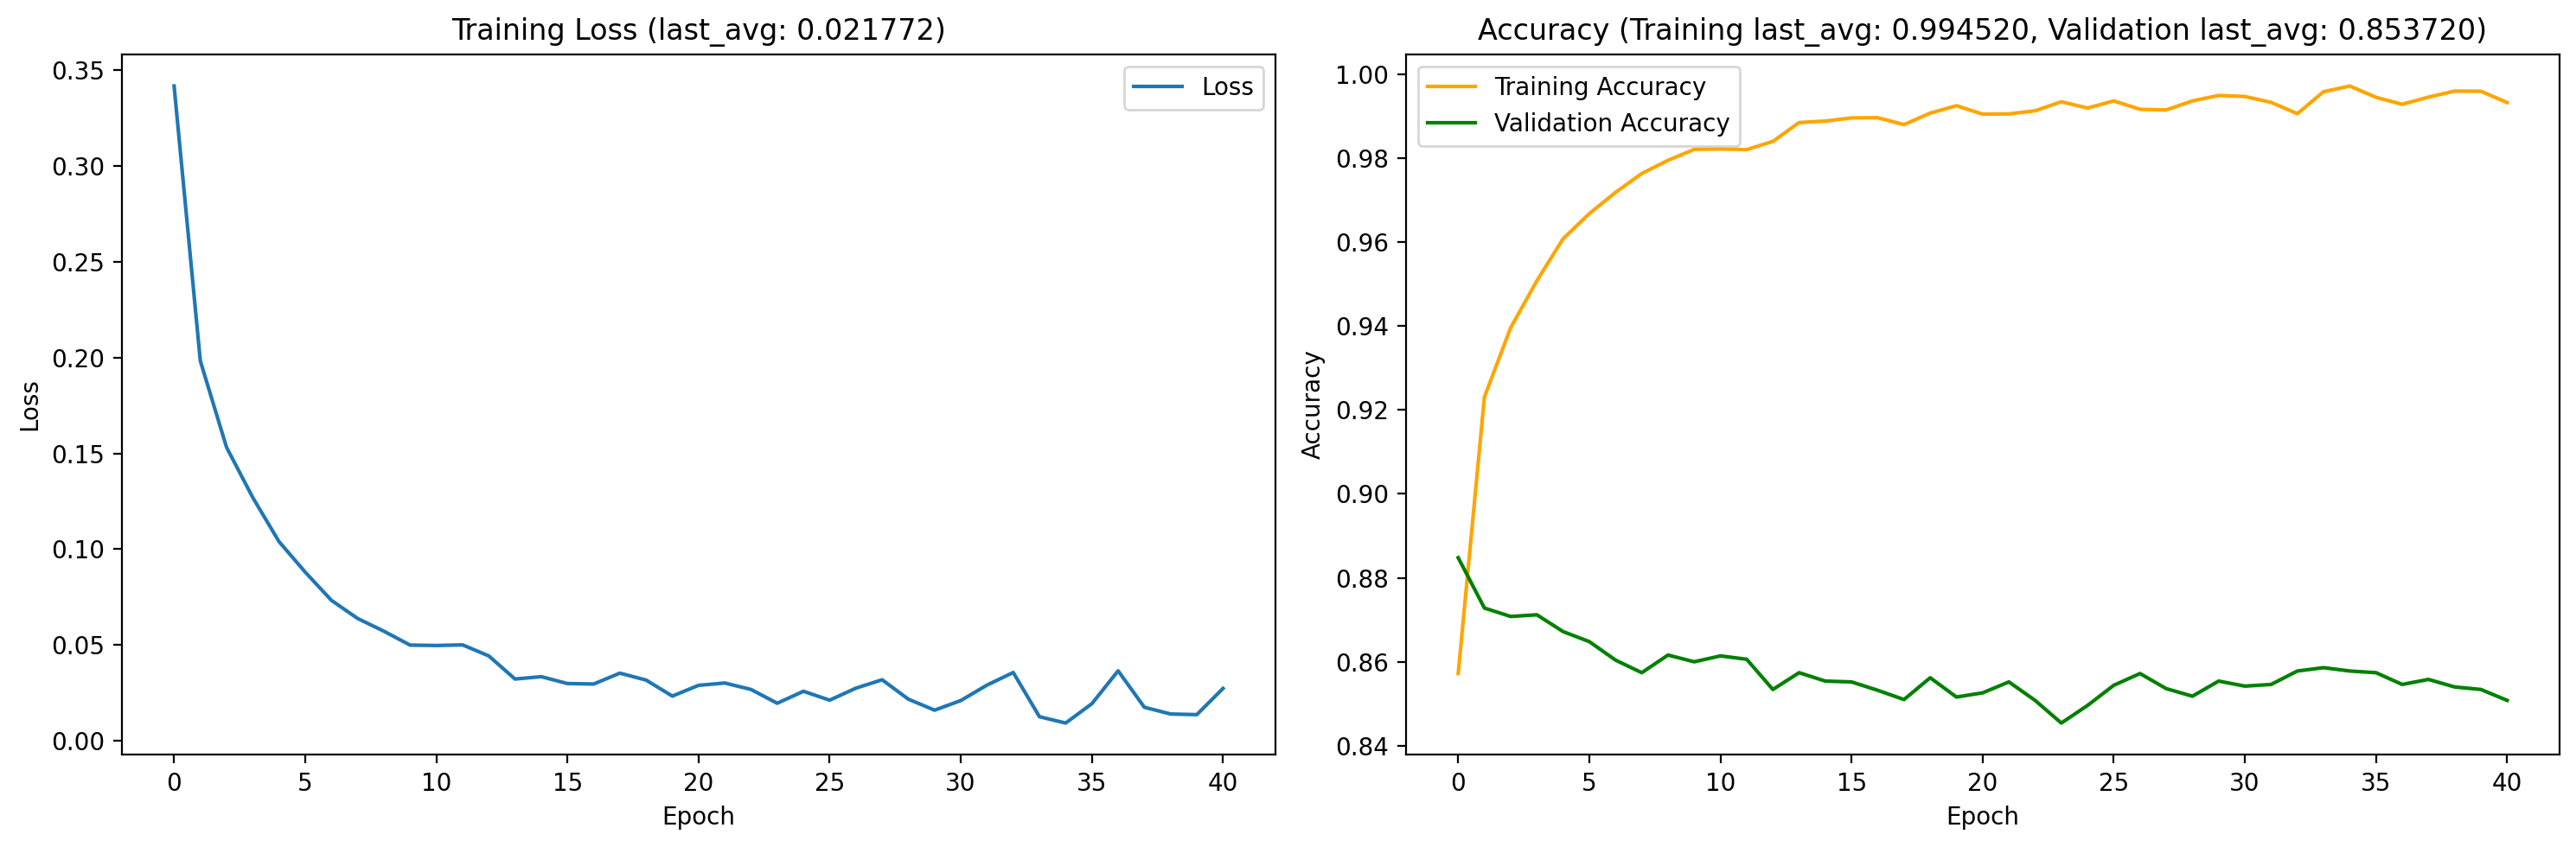

In [34]:
model, losses = train(model, x_train, y_train, x_valid, y_valid, loss_function=lfn, optimizer=opt, epochs=epochs)

In [35]:
# Ok so this kinda works. Lets now try to do it with another way of encoding data
# Explain multihot

# Lets do the bag of words representation really quickly
Xm = torch.zeros((n_docs, n_words), dtype=torch.float32)
Ym = torch.tensor(train_labels, dtype=torch.float32).reshape(-1, 1)

# For each document, update a row of this matrix
for i, doc in enumerate(tqdm(train_docs)):
    for tokid in doc:
        Xm[i][tokid] += 1

Xm.shape, Ym.shape

100%|██████████| 25000/25000 [00:26<00:00, 951.31it/s] 


(torch.Size([25000, 10002]), torch.Size([25000, 1]))

In [36]:
xm_train, xm_valid, ym_train, ym_valid = train_test_split(Xm, Ym, test_size=0.2, random_state=42)

In [37]:
model = NonLin(n_words)
lfn = torch.nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
epochs = 20

print(model)

NonLin(
  (t1): Linear(in_features=10002, out_features=100, bias=False)
  (t3): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
model, losses = train(model, xm_train, ym_train, xm_valid, ym_valid, loss_function=lfn, optimizer=opt, epochs=200)

Epoch 28/200 - Loss: 0.204338 - Tracc: 0.922 - Vlacc: 0.862:  14%|█▍        | 29/201 [00:41<03:50,  1.34s/it]